# Lab-11: Bayesian Modeling For Data Science

This lab covers the basic fundamentals of Bayesian modelling and its application to data science.

References:
1. https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/tree/master
2. https://ethen8181.github.io/machine-learning/clustering/topic_model/LDA.html  

## Imports

In [1]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

from gensim import corpora
from gensim.models import LdaModel

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Goals

This lab aims to answer the following questions:

- What are the differences between Bayesian and frequentist perspectives?
- What is Bayes' rule and why is it useful?
- What are generative and inference processes and how do they relate to each other?
- How do we write code for Bayesian modeling using PyMC3?
- What are the applications of Bayesian modeling in data science?
- Apply PyMC to modeling a behavioural switchpoint detection problem in a time series of texting interactions

## Introduction to Bayesian Modeling

### Biased Coin Problem

Suppose we have a biased coin that we flip repeatedly and note the side it lands on.

The outcome of a coin flip can be summarized as follows:

$$P(heads) = p, \; P(tails) = 1-p, \; p \in [0,1]$$

We have access to a set of experiment outcomes from repeatedly flipping the coin, and want to use it to estimate $p$ which is unknown.

### Bayesian vs. Frequentist Perspectives

#### Frequentist Perspective

Probabilities are long-run frequency of events. In other words, the probability of an event is the proportion of the times the event occurs if we repeated the experiment an infinite number of times.  

In [3]:
# Function to simulate biased coin flips and plot a line graph of the proportion of heads

def biased_coin_flips(prob_heads, n_flips):

    # Simulate coin flips
    ## Generate random number between 0 and 1 n_flips times
    ## If the number is less than prob_heads, outcome of the flip is heads, otherwise tails
    flips = np.random.rand(n_flips) < prob_heads # True (1) for heads, False (0) for tails

    # Calculate proportion of heads
    ## Example: a = np.cumsum([True, False, True]) = [1, 1, 2], b = np.arange(1, 4) = [1, 2, 3], a/b = [1, 0.5, 0.67]
    p_heads = np.cumsum(flips) / np.arange(1, n_flips + 1)

    # Plot the results
    plt.plot(p_heads)
    plt.plot(np.ones(n_flips) * prob_heads, 'k--') # Add a horizontal dashed line at the true probability of heads
    plt.xlabel('Number of flips')
    plt.ylabel('Proportion of heads')
    plt.show()

    # Return proportion of heads
    return p_heads[-1] # Last element of the array

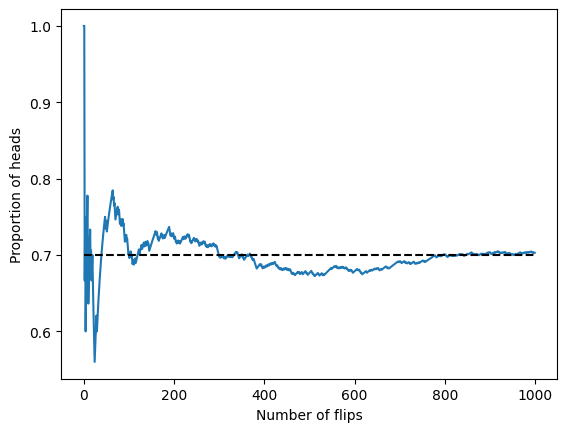

Estimated probability of heads: 0.703


In [4]:
# Set the probability of heads and the number of flips
prob_heads = 0.7
n_flips = 1000

# Call the function
p_est = biased_coin_flips(prob_heads, n_flips)

# Print the estimated probability
print('Estimated probability of heads:', p_est)

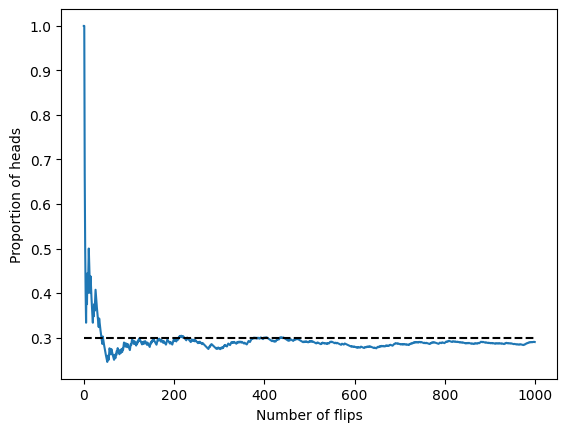

Estimated probability of heads: 0.29


In [5]:
# Set the probability of heads and the number of flips
prob_heads = 0.3
n_flips = 1000

# Call the function
p_est = biased_coin_flips(prob_heads, n_flips)

# Print the estimated probability
print('Estimated probability of heads:', p_est)

In both cases, the proportion of heads converges to the true value of $p$ as the number of flips approaches infinity.

#### Bayesian Perspective

Probabilites are measures of belief or confidence of an event occurring. We possess prior beliefs about events, which are updated as we observe data.  

Let's illustrate what this means using the biased coin flip example.

Initially, without conducting any experiments, it is fair to assume the prior distribution of $p$ to be uniform. This means that all settings of $p$ are equally likely.

$$P(p) = U(0,1)$$

Here, $U(0,1)$ represents a uniform distribution over the interval 0 to 1, which aligns with the condition that $p \in [0,1]$.

Once we start to run experiments (i.e. repeatedly flip the coin), we can use the results $X$ to update the prior. As we continue to do this, the posterior $P(p|X)$ (think for now as the updated prior conditioned on the observations $X$) should favor (or have higher belief) values close to $p$.

How we "update the prior" (i.e. obtain the posterior distribution) will be covered shortly. For now, it is important to focus on the intuition of how the beliefs would update given an observation set $X$. The code below helps reinforce this - focus on the input/output, ignore the actual code of the function.

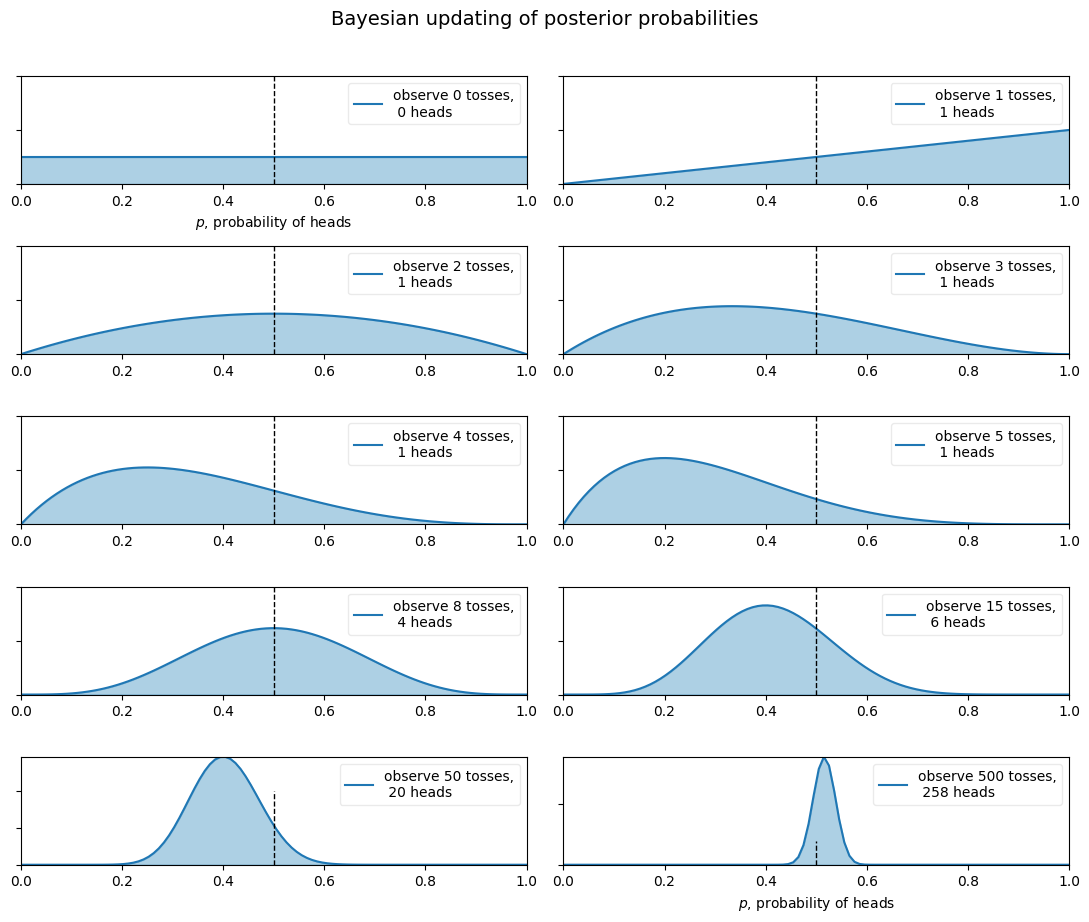

In [6]:
# The code below can be passed over, as it is currently not important, plus it
# uses advanced topics we have not covered yet. LOOK AT PICTURE!

# Covers case of p=0.5 (fair coin)

from IPython.core.pylabtools import figsize
figsize(11, 9)

import scipy.stats as stats

dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])
x = np.linspace(0, 1, 100)

# For the already prepared, I'm using Binomial's conj. prior.
for k, N in enumerate(n_trials):
    sx = plt.subplot(len(n_trials)//2, 2, k+1)
    plt.xlabel("$p$, probability of heads") \
        if k in [0, len(n_trials)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = dist.pdf(x, 1 + heads, 1 + N - heads)
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities",
             y=1.02,
             fontsize=14)

plt.tight_layout()

Initially, we start with a uniform distribution. The prior beliefs are updated after every result. As we increase the number of flips, the beliefs become much more confident for values close to $p=0.5$ which is the $p$ value that was used for these experiments.

Notice the difference between Bayesian and frequentist perspectives.
- The frequentist approach assigned $p$ to be the ratio of the number of heads to the total number of flips
- The Bayesian approach maintains beliefs over all values of $p$ based on experimental results - it is a probability distribution, not a singular value

Note that the initial prior belief doesn't always have to be uniform - it depends on the problem (e.g. can be Gaussian or any other distribution). The general takeaway is that it will be updated to better fit experimental results.

### Bayes' Rule

Bayes' rule is the fundamental theorem that all of Bayesian modeling builds upon.

$$P(\theta|X) = \frac{P(X|\theta)P(\theta)}{P(X)}$$

Definitions of relevant variables/quantities:
- $X$: observation set, data, or evidence
- $\theta$: set of model parameters
- $P(\theta)$: **prior** belief of model parameters without any evidence
- $P(\theta|X)$: **posterior** belief of model parameters given evidence
- $P(X|\theta)$: **likelihood** of data given model parameters
- $P(X)$: normalization constant (to ensure posterior distribution sums to 1)
    - Discrete case (model parameters are discrete): $\sum_{\theta \in \Theta} P(X|\theta)P(\theta)$
    - Continuous case (model parameters are continuous): $\int_{\theta \in \Theta} P(X|\theta)P(\theta) d\theta$
    - $\theta \in \Theta$ means to sum over all possible values of $\theta$

Here the term "model" refers to the joint distribution $P(X,\theta)$ which is equivalent to the numerator of Bayes' rule:

$$P(X,\theta) = P(X|\theta)P(\theta)$$

 If $θ$ is continuous, then $P(θ)$ and $P(θ|X)$ are **probability density functions (PDF)**. The same applies to $P(X)$ and $P(X|θ)$ if $X$ is continuous.

 If $θ$ is discrete, then $P(θ)$ and $P(θ|X)$ are **probability mass functions (PMF)**. The same applies to $P(X)$ and $P(X|θ)$ if $X$ is discrete.

 PMFs refer to the probability distributions we are accustomed to seeing - they return the likelihood of a discrete random variable taking on a particular value (e.g. $P(X=x)$) and sums to 1 ($∑_iP(X=x_i)=1$).

 PDFs return probability densities as opposed to direct probabilities, these densities can be interpreted as "relative likelihoods". They describe the probabilities of ranges of continuous values. Some properties of the PDF $f(X)$ include the following:
 - $P(a < x < b) = ∫_{a}^{b} f(x) $
 - $∫_{-∞}^{+∞} f(x) = 1$




#### Revisiting Unbiased Coin Example

In the case of the unbiased coin example, there is only one model parameter $p$ so $\theta = \{{p}\}$. As mentioned before, $X$ is the outcomes of coin flips.

Note that models can have more than one parameter. For example, we can have the parameter set $\theta=\{{\mu,\sigma^2}\}$ where the likelihood is a Gaussian $P(X|\theta) = \mathcal{N}(\mu,\sigma^2)$. Here $\mu$ represents the mean and $\sigma^2$ represents the variance.

In most cases, the parameters are independent of each other, so they would have separate prior distributions. In other words, $P(\theta) = P(\mu)P(\sigma^2)$, assuming independence holds.

##### Prior: Beta Distribution

The standard prior distribution used for this example is the Beta distribution, which is defined as follows:

$$P(p|\alpha,\beta) = \frac{1}{B(\alpha,\beta)}p^{\alpha-1}(1-p)^{\beta-1} \equiv Beta(p|\alpha,\beta)$$

Here $\alpha$ and $\beta$ are hyperparameters that inform what your beliefs are, and $B(\alpha,\beta)$ is a normalization constant.

Let's visualize this prior distribution with various $\alpha$ and $\beta$ hyperparameter settings.

In [7]:
# Function to simulate Beta distribution for different hyperparameters

def simulate_beta(a, b):

    # Generate 1000 points between 0 and 1
    x = np.linspace(0, 1, 1000)

    # Calculate the Beta distribution for the 1000 points
    y = stats.beta.pdf(x, a, b)

    # Return x and y
    return x, y

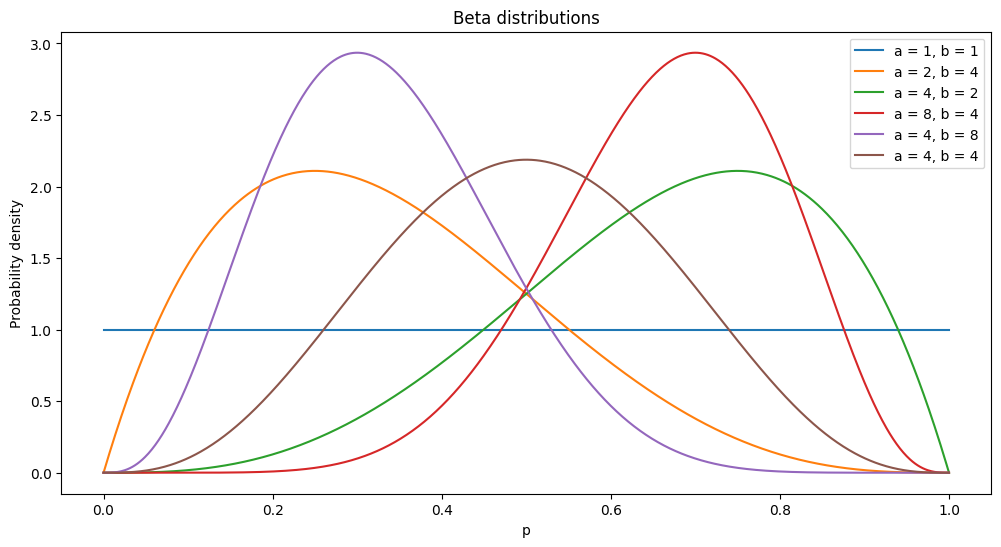

In [8]:
# List of hyperparameter settings (a, b)
hyperparameters = [(1, 1), (2, 4), (4, 2), (8, 4), (4, 8), (4, 4)]

# Plot Beta distributions on same plot
plt.figure(figsize=(12, 6))
for a, b in hyperparameters:
    x, y = simulate_beta(a, b)
    plt.plot(x, y, label=f'a = {a}, b = {b}')
plt.xlabel('p')
plt.ylabel('Probability density')
plt.title('Beta distributions')
plt.legend()
plt.show()

Note that the Beta distribution is a probability density function (PDF) since the variable $p$ is continuous. The y-axis represents densities, not probabilities which is why values are not constrained between 0 and 1. Properties of this PDF include:

$$\int_{0}^{1} P(p)dp = 1$$
$$P(a < p < b) = \int_{a}^{b} P(p)dp$$

Visualizing the PDF still provides insights about the beliefs - the larger the density, the higher the belief.

The key takeaway is that the hyperparameters influence the beliefs, and illustrates that we can define a prior that aligns with what we think the beliefs are. A breakdown of each prior in the plot above and the beliefs they convey is provided below.

- Blue ($\alpha=1, \beta=1$): belief that all p-values are equally likely (uniform prior)
- Orange ($\alpha=2, \beta=4$) + purple ($\alpha=4, \beta=8$): beliefs are biased towards lower values of $p$
- Green ($\alpha=4, \beta=2$) + red ($\alpha=8, \beta=4$): beliefs are biased towards higher values of $p$
- Brown ($\alpha=4, \beta=4$): beliefs are biased towards the coin being a fair coin ($p=0.5$)

##### Likelihood: Bernouilli Distribution

The Bernouilli likelihood is defined as:

$$P(x_i) = \left\{\begin{array}{ll}
  p & x_i=1 ~ (True) \\
  1-p & x_i=0 ~ (False) \\
\end{array} \right. $$

From this definition, the likelihood of $N$ independent Bernouilli samples can be written as:

$$P(X|p) = \prod_{i=1}^{N} p^{x_i}(1-p)^{1-x_i}$$

where:
- $N$ is the number of flips
- $X = \{{x_1, x_2, ..., x_N}\}$ is the observed outcomes of $N$ flips where $x=1$ represents heads and $x=0$ represents tails

Note that because observed data samples are i.i.d (independently and identically distributed), the likelihood of $X$ can be represented as the product of the likelihood of each $x_i$.

Since $p \leq 1$, the likelihood may encounter underflow issues (i.e. probabilities are non-zero but too small to represent in memory so they round to 0), so it is common to take log-likelihood (product becomes sum by log property).

$$log(P(X|p)) = \sum_{i=1}^{N} x_i log(p) + (1-x_i)log(1-p)$$

$log(x)$ is a monotonic function - meaning that it preserves relevant ordering (i.e. $x_1 > x_2$ then $log(x_1) > log(x_2)$) so it used in many applications to simulate likelihood.

Let's visualize this likelihood function for 5 flips, with various $p$ values.

In [9]:
# Function to compute Bernoulli log-likelihood for different p and outcomes

def simulate_bernoulli(p, outcomes):

    # Calculate the iid Bernoulli log likelihood for the outcomes
    y = np.sum(outcomes)*np.log(p) + np.sum(1-outcomes)*np.log(1-p)

    # Return log-likelihood
    return y

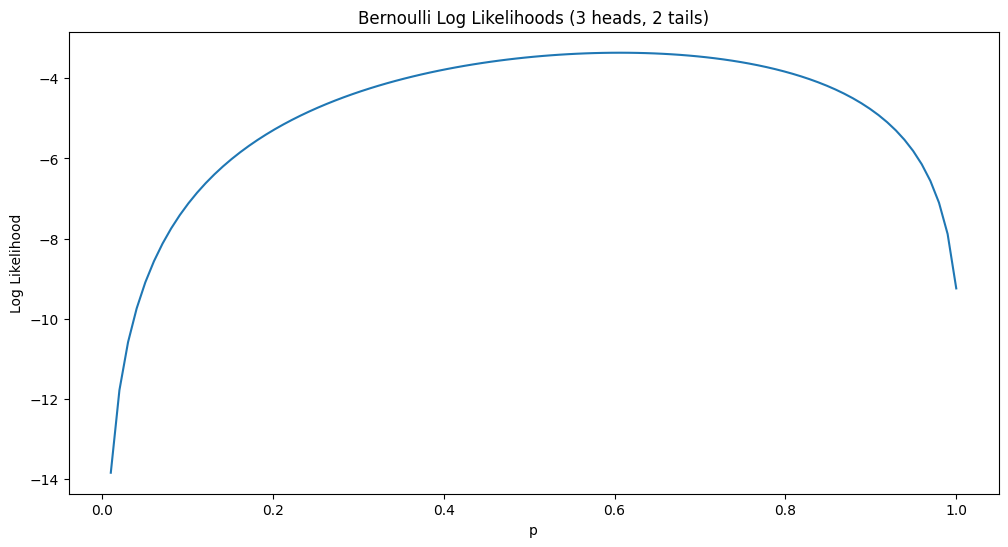

In [10]:
# Set the outcomes, 1 for heads and 0 for tails
outcomes = np.array([1, 0, 0, 1, 1])

# Calculate Bernoulli log likelihoods for different p values
likelihoods = []
for p in range(0, 100, 1):
    p /= 100
    likelihoods.append(simulate_bernoulli(p, outcomes))

# Plot Bernoulli log likelihoods for different p values
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, 1, 100), likelihoods)
plt.xlabel('p')
plt.ylabel('Log Likelihood')
plt.title('Bernoulli Log Likelihoods (3 heads, 2 tails)')
plt.show()

**Question:** At what range of $p$ values does likelihood peak and does this make sense.

**Answer:** Higher values of $p$ (around $p=0.6$) result in higher log-likelihood, which makes sense given the outcome was 3 heads and 2 taiils.

##### Posterior: Beta Distribution

The posterior can be evaluated using Bayes' rule. It can be evaluated to be:

$$P(p|X) = Beta(p|h+\alpha,t+\beta) = \frac{1}{B(h+\alpha,t+\beta)} p^{h+\alpha-1}(1-p)^{t+\beta-1}$$

where $h$ is the number of heads observed and $t$ is the number of tails observed.

An interesting fact is that by selecting the prior to be a Beta distribution, the posterior will also be a Beta distribution. This is because the Beta distribution is the **conjugate prior** of the Bernoulli likelihood function. This tidbit is optional content that won't be tested on.

Let's visualize this posterior distribution for $N=20$ flips, fixing $\alpha=1$ and $\beta=1$ (i.e. uniform prior distribution).

In [11]:
# Function to simulate Beta posterior for different hyperparameters

def simulate_beta_posterior(a, b, h, n):

    # Calculate the posterior hyperparameters
    a_post = a + h
    b_post = b + n - h

    # Generate 1000 points between 0 and 1
    x = np.linspace(0, 1, 1000)

    # Calculate the Beta posterior for the 1000 points
    y = stats.beta.pdf(x, a_post, b_post)

    # Return x and y
    return x, y

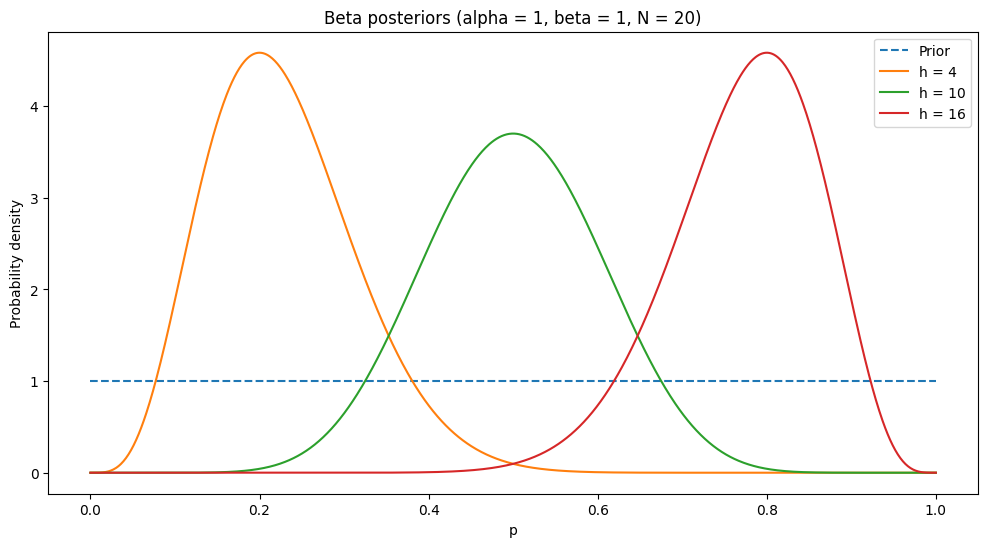

In [12]:
# List of hyperparameter settings (a, b, h, n), fix n = 20, a = 1, b = 1

hyperparameters = [(1, 1, 4, 20), (1, 1, 10, 20), (1, 1, 16, 20)]

# Plot Beta posteriors and uniform prior on same plot

prior_x, prior_y = simulate_beta(1, 1)

plt.figure(figsize=(12, 6))
plt.plot(prior_x, prior_y, label='Prior', linestyle='--')
for a, b, h, n in hyperparameters:
    x, y = simulate_beta_posterior(a, b, h, n)
    plt.plot(x, y, label=f'h = {h}')
plt.xlabel('p')
plt.ylabel('Probability density')
plt.title('Beta posteriors (alpha = 1, beta = 1, N = 20)')
plt.legend()

Notice that the posterior beliefs favor lower values of $p$ when there are fewer heads and vice-versa. When 10 heads are observed, the posterior beliefs favor values of $p$ around 0.5. In other words, the posterior adjusts prior beliefs by accounting for data realizations.

### Generative and Inference Processes

#### Generative Process

A generative process is the formal definition of how to sample (i.e. generate) data from a model $p(X,\theta)$. Sampling is the process of randomly selecting possible events (or outcomes) of a random variable based on its probability distribution. The notation $x \sim P(X)$ means an event $X=x$ was sampled from $P(X)$.

The sampling process can be generalized as follows:

$$\theta \sim P(\theta)$$
$$x \sim P(X|\theta)$$

First, the parameters are sampled from their prior distributions, then data samples are generated conditioned on the sampled parameters.

In the case of the unbiased coin example, if we assume a uniform prior (i.e. $\alpha=1, \beta=1$), then the generative process is:

$$p \sim Beta(P|1,1) = U(0,1)$$
$$x \sim p^{X}(1-p)^{1-X} \equiv Bern(X|p)$$

Note the likelihood is for a **single** observation ($X=1$ is heads, $X=0$ is tails), which is different from determining the likelihood of N observations given $p$.


Generative processes can be summarized into diagrams referred to as graphical models. The arrows show dependencies between variables, and the plate (rectangle in the diagram) represents i.i.d samples. The graphical model of $N$ coin flips based on the generative process described above is shown below.

<center><img src="https://raw.githubusercontent.com/MIE223-2024/course-datasets/main/beta_bernouilli_gm.png"><center>

#### Inference Process

The inference process refers to computing the posterior beliefs, $p(\theta|X)$, provided the generative process and observed data samples.

This is simply the application of Bayes' rule since access to the generative process implies access to definitions of prior distributions, $P(\theta)$, and the likelihood function, $P(X|\theta)$.

## PyMC Tutorial

Python's PyMC package simplifies the code for Bayesian inference and allows us to model both simple and complex (non-conjugate) Bayesian generative models.

### PyMC Implementation of Biased Coin Toss


Mean: 0.5685157170239906
94% HDI: [0.24417271 0.8804576 ]


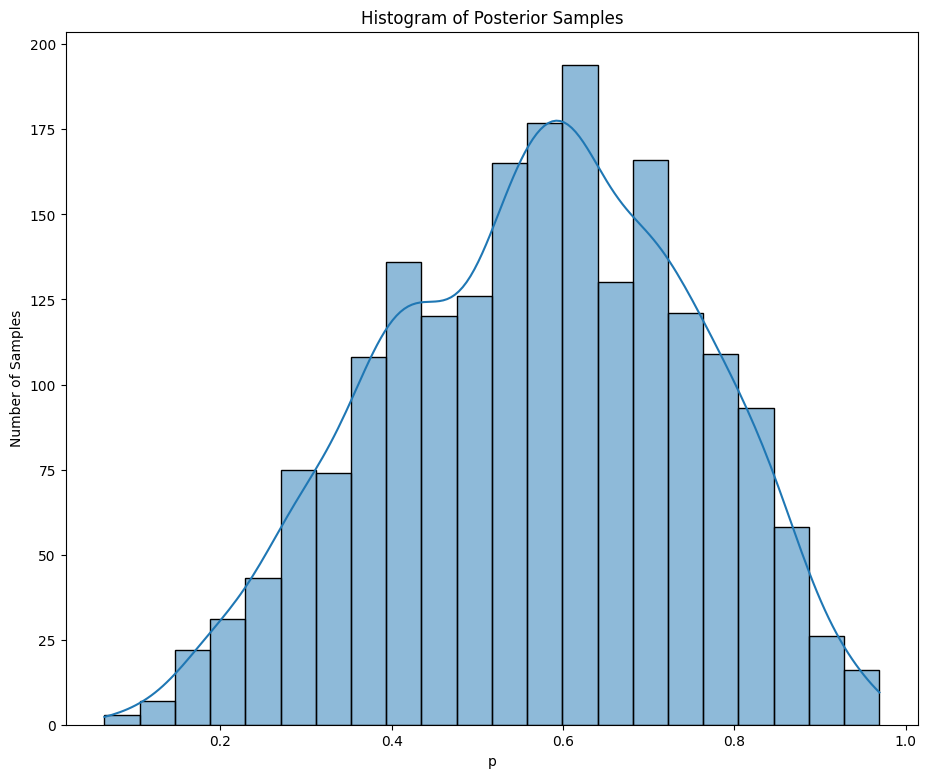

In [13]:
# # PyMC implementation of biased coin toss

# Observed outcomes, 1 for heads and 0 for tails
outcomes = np.array([1, 0, 0, 1, 1])

# Define model

coin_flip_model = pm.Model()

with coin_flip_model:

    # Define priors
    p = pm.Beta('p', alpha=1, beta=1)

    # Define likelihood
    likelihood = pm.Bernoulli('likelihood', p=p, observed=outcomes)

    # Bayesian inference to approximate posterior (uses MCMC - outside of course scope)
    trace = pm.sample(1000, random_seed=100)

# Plot histogram of posterior samples
sns.histplot(trace.posterior['p'].values.flatten(), kde=True)
plt.xlabel('p')
plt.ylabel('Number of Samples')
plt.title('Histogram of Posterior Samples')

# Mean of posterior samples and 94% HDI
print(f"\nMean: {np.mean(trace.posterior['p'].values.flatten())}")
hdi = az.hdi(trace.posterior['p'].values.flatten())
print(f"94% HDI: {hdi}")

**Question:** What is this plot and why isn't it as smooth as the previous PDFs?

**Answer:** This plot is a histogram of **samples** drawn from the **posterior**. This plot isn't as smooth as the previous PDFs because it is an approximation of the posterior (through sampling). The visualization is still useful to draw conclusion about posterior beliefs.

The posterior shows higher beliefs for values around $p=0.6$ (mean: $p=0.57$). This makes sense given 3/5 observations was heads. The 94% HDI (highest density interval) indicates that 94% of the samples (or probability density) is within the range $0.24 \leq p \leq 0.88$.  


Mean: 0.5981269034685547
94% HDI: [0.50331159 0.67879147]


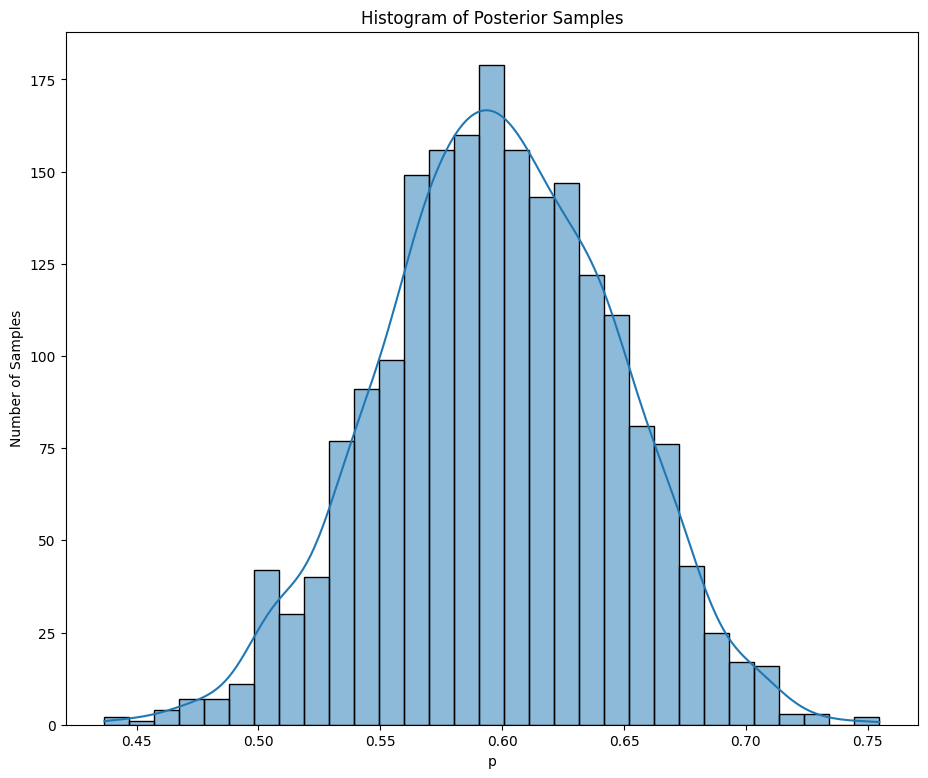

In [14]:
# Observed outcomes (60 heads, 40 tails)
outcomes = np.concatenate([np.ones(60), np.zeros(40)])

# Define model

coin_flip_model = pm.Model()

with coin_flip_model:

    # Define priors
    p = pm.Beta('p', alpha=1, beta=1)

    # Define likelihood
    likelihood = pm.Bernoulli('likelihood', p=p, observed=outcomes)

    # Bayesian inference to approximate posterior (uses MCMC - outside of course scope)
    trace = pm.sample(1000, random_seed=100)

# Plot histogram of posterior samples
sns.histplot(trace.posterior['p'].values.flatten(), kde=True)
plt.xlabel('p')
plt.ylabel('Number of Samples')
plt.title('Histogram of Posterior Samples')

# Mean of posterior samples and 94% HDI
print(f"\nMean: {np.mean(trace.posterior['p'].values.flatten())}")
hdi = az.hdi(trace.posterior['p'].values.flatten())
print(f"94% HDI: {hdi}")

Note that with more observed data samples (same ratio - 60% heads, 40% tails), the range of the 94% HDI decreases ($0.50 \leq p \leq 0.68$) implying the posterior is more confident in its beliefs. This makes sense as with more coin flips, the ratio of heads to the total outcomes should converge to the true value of $p$.

## Generative Bayesian Modeling For Data Science

Bayesian modeling decomposes real-world data science problems by assuming available data was sampled from a generative model. The task then is to infer the latent parameters of the model.

### Example: Inferring behaviour from text-message data

You are given a series of daily text-message counts from a user of your system. The data, plotted over time, appears in the chart below. You are curious to know if the user's text-messaging habits have changed over time, either gradually or suddenly. How can you model this?

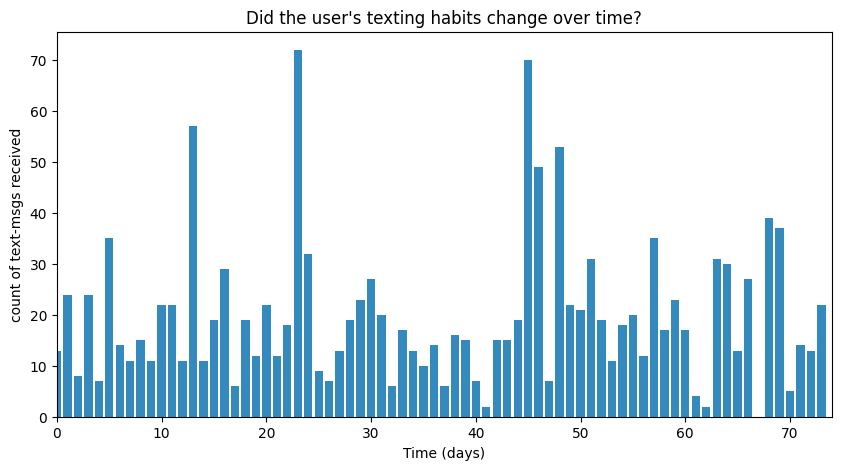

In [15]:
# Retrieve text message data
count_data = np.loadtxt("https://raw.githubusercontent.com/MIE223-2024/course-datasets/main/txtdata.csv")

# Plot text messages received over time
n_count_data = len(count_data)
plt.figure(figsize=(10,5))
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

In [16]:
n_count_data

74

#### Defining a Generative Bayesian Model

Before we define a generative Bayesian model describing how the data was generated, we should look at observable trends in the data that will help us choose an appropriate model.

One trend is that on average, a higher number of text messages were received later on in the observation period (45+ days) compared to before it. The point at which this does occur is called a **switchpoint**.

Now how do we formalize this problem as a generative Bayesian model that accounts for the switchpoint trend?

First, we assume the count of text messages received ($C$) is a Poisson random variable. A Poisson random variable is very common for modeling counts. The Poisson distribution is defined as follows:

$$P(x;λ) = \frac{λ^xe^{-λ}}{x!}$$

where $x$ is the count and $λ>0$ is a model parameter. Generally, λ represents the mean number of events within a given time interval.

With this assumption, all instances $c_i$ of $C$ can be written as:

$$c_i ∼ Poisson(λ)$$

For more clarity, let's visualize the Poission distribution for various $λ$ values. The general trend is that the higher λ is, the more likely larger counts become (and vice-versa).

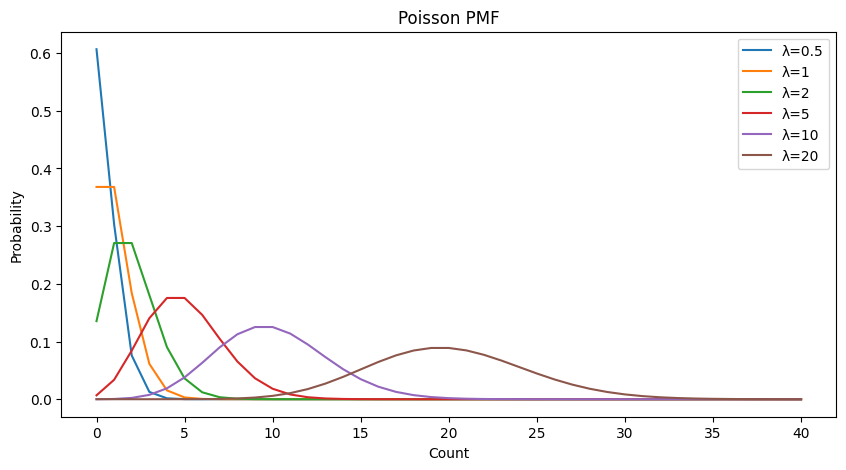

In [17]:
# Function to simulate Poisson PMF

def simulate_poisson(lambda_val, n):

    # Counts from 0 to n
    x = np.arange(n+1)

    # Poisson PMF
    y = stats.poisson.pmf(x, lambda_val)

    # Return x and y
    return x, y

# Plot Poisson PMF for n=20 and several λ
n = 40
plt.figure(figsize=(10,5))
lambda_vals = [0.5, 1, 2, 5, 10, 20]
for lambda_val in lambda_vals:
    x, y = simulate_poisson(lambda_val, n)
    plt.plot(x, y, label=f"λ={lambda_val}")
plt.xlabel("Count")
plt.ylabel("Probability")
plt.title("Poisson PMF")
plt.legend()
plt.show()

Now let's account for the switchpoint. Since we know that a higher $λ$ increases the probability for higher values, then after some time $τ$, we propose that $λ$ increases. More formally:

$$λ = \left\{\begin{array}{ll}
  λ_1 & t ≤ τ \\
  λ_2 & t > τ \\
\end{array} \right. $$

The final step is to assign a prior distribution to the parameters $λ_1$, $λ_2$, and $τ$. Due to the noise of the data, it is difficult to pinpoint exactly where the switchpoint happens, so we simply assign $τ$ a discrete uniform prior.  

$$τ ∼ U\{0,73\}$$

$λ_1$ and $λ_2$ are non-negative continuous variables, so we could use Gamma priors (outside course scope: Gamma distribution is conjugate prior of Poisson likelihood so $λ_1$ and $λ_2$ will also have Gamma posteriors). Instead, we opt for **exponential** priors, which is also only defined for non-negative values:

$$f(x;α) = αe^{-αx}$$
$$λ_1, λ_2 \sim exp(α)$$

where $α>0$. The reason we pick exponential priors is to leverage the following property:

<center>If $Z ∼ exp(\alpha)$ then $\mathbb{E}[Z|α] = \frac{1}{α}$</center>

This is useful because it was mentioned earlier than $λ$ loosely represents the mean count over an interval. This means that we can set $α$ to the inverse of this quantity, which can be computed using the provided data.



In [18]:
alpha = 1/np.mean(count_data)
alpha

0.05065023956194388

To summarize, the generative process is:

$$τ ∼ U\{0,73\}$$
$$λ_1, λ_2 \sim exp(0.05)$$
$$λ = \left\{\begin{array}{ll}
  λ_1 & t ≤ τ \\
  λ_2 & t > τ \\
\end{array} \right. $$
$$c_i ∼ Poisson(λ)$$

The graphical model of the generative process is as follows:

<center><img src="https://raw.githubusercontent.com/MIE223-2024/course-datasets/main/switchpoint_gm.png"><center>



#### Inference Process using PyMC

Provided the generative Bayesian model definition and the data samples, we can use PyMC to approximate the posteriors of the parameters.

In [19]:
switchpoint_model = pm.Model()

with switchpoint_model:

    # Prior distributions
    tau = pm.DiscreteUniform("τ", lower=0, upper=n_count_data-1)
    lambda_1 = pm.Exponential("λ_1", 1/np.mean(count_data))
    lambda_2 = pm.Exponential("λ_2", 1/np.mean(count_data))

    # Switchpoint
    idx = np.arange(n_count_data)
    lambda_ = pm.math.switch(idx < tau, lambda_1, lambda_2)

    # Likelihood
    count = pm.Poisson("count", lambda_, observed=count_data)

    # Bayesian inference to approximate posterior
    trace = pm.sample(1000, random_seed=100)


Mean of τ: 44.303
94% HDI of τ: [43 45]


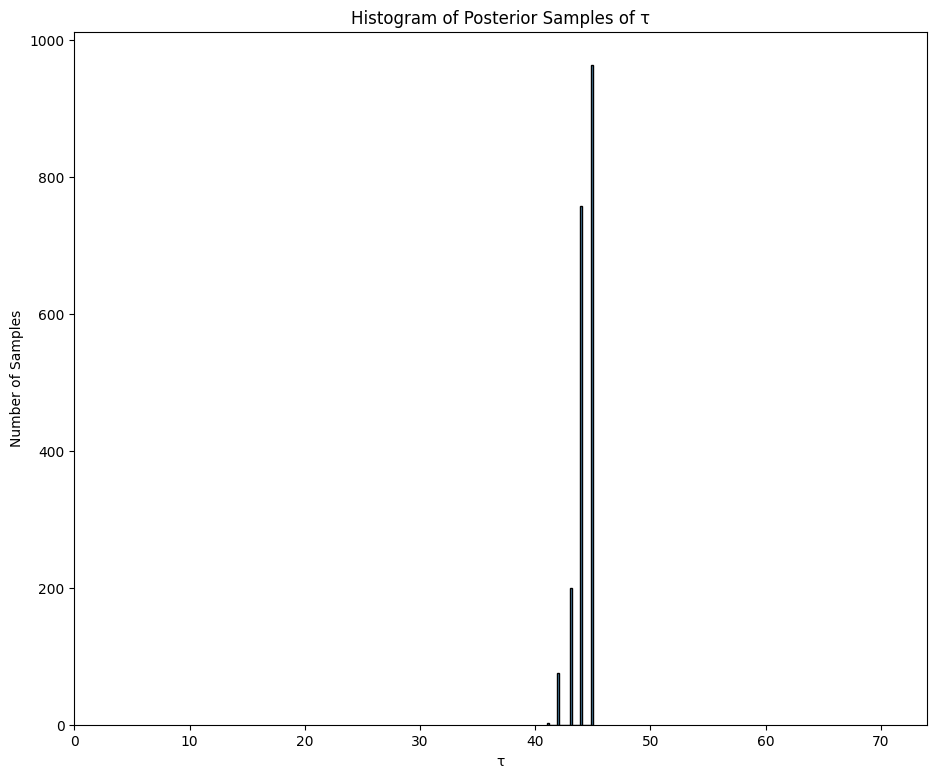

In [20]:
# Plot histogram of posterior samples for τ
ax = sns.histplot(trace.posterior['τ'].values.flatten())
ax.set_xlim(0, n_count_data)
plt.xlabel('τ')
plt.ylabel('Number of Samples')
plt.title('Histogram of Posterior Samples of τ')

# Mean of posterior samples and 94% HDI
print(f"\nMean of τ: {np.mean(trace.posterior['τ'].values.flatten())}")
hdi = az.hdi(trace.posterior['τ'].values.flatten())
print(f"94% HDI of τ: {hdi}")


Mean of λ_1: 17.740624470309413
94% HDI of λ_1: [16.55601509 18.94159825]


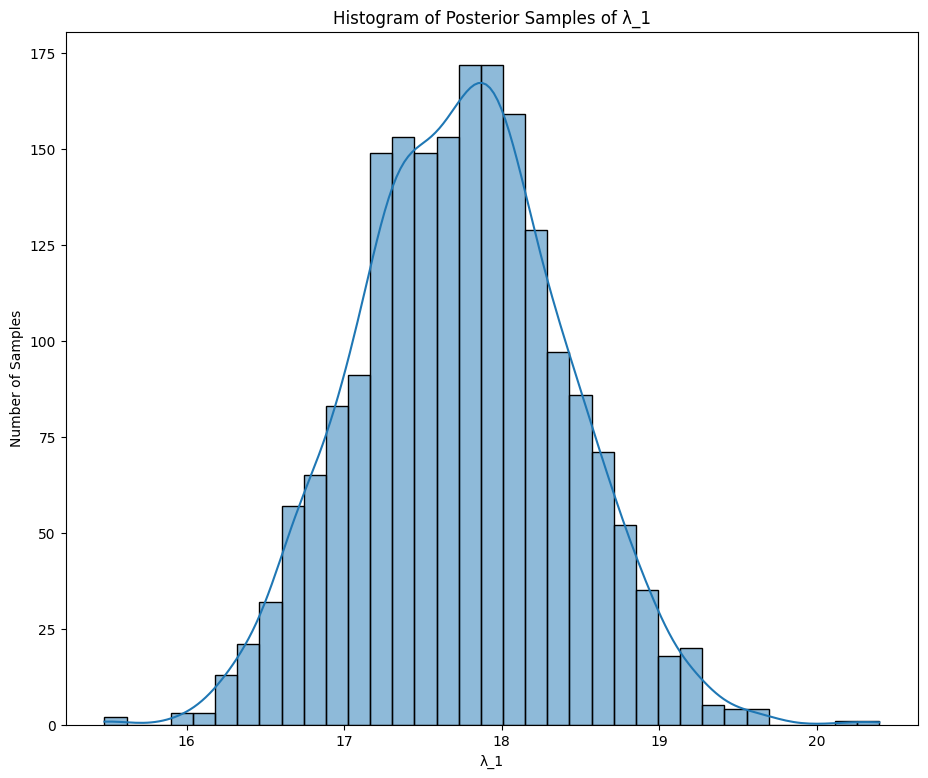

In [21]:
# Plot histogram of posterior samples for λ_1
ax = sns.histplot(trace.posterior['λ_1'].values.flatten(), kde=True)
plt.xlabel('λ_1')
plt.ylabel('Number of Samples')
plt.title('Histogram of Posterior Samples of λ_1')

# Mean of posterior samples and 94% HDI
print(f"\nMean of λ_1: {np.mean(trace.posterior['λ_1'].values.flatten())}")
hdi = az.hdi(trace.posterior['λ_1'].values.flatten())
print(f"94% HDI of λ_1: {hdi}")


Mean of λ_2: 22.6957366289422
94% HDI of λ_2: [21.0535623  24.31679357]


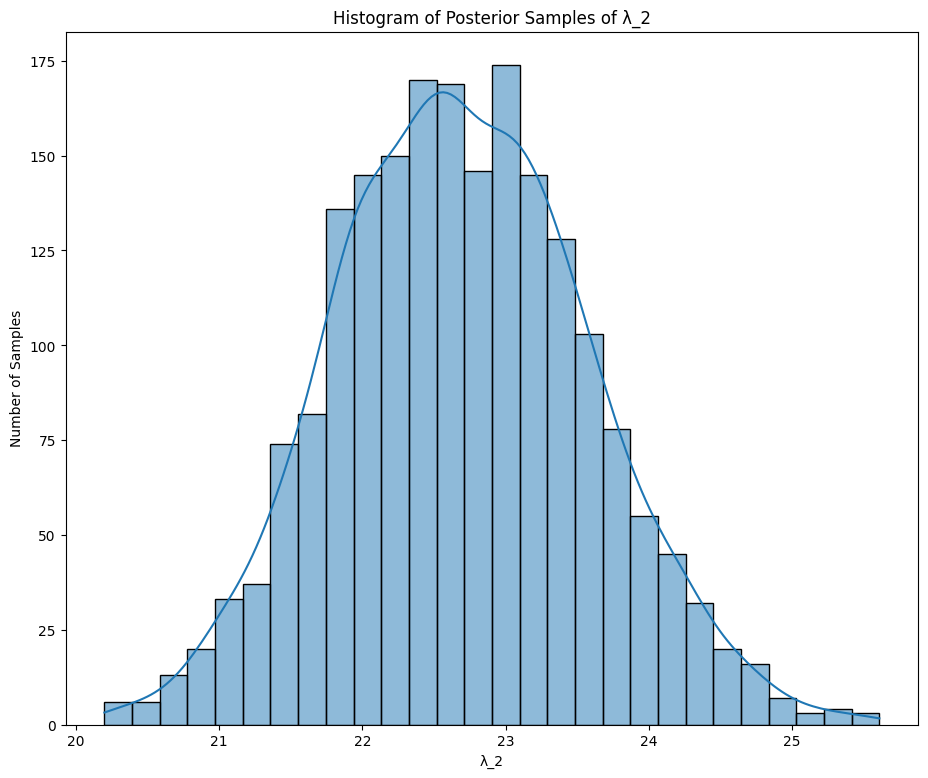

In [22]:
# Plot histogram of posterior samples for λ_2
ax = sns.histplot(trace.posterior['λ_2'].values.flatten(), kde=True)
plt.xlabel('λ_2')
plt.ylabel('Number of Samples')
plt.title('Histogram of Posterior Samples of λ_2')

# Mean of posterior samples and 94% HDI
print(f"\nMean of λ_2: {np.mean(trace.posterior['λ_2'].values.flatten())}")
hdi = az.hdi(trace.posterior['λ_2'].values.flatten())
print(f"94% HDI of λ_2: {hdi}")

Notice that the switchpoint beliefs are concentrated around 41-46, which aligns with the original remarks about the switchpoint trend. $λ_2$ is greater than $λ_1$ which also aligns with the increase in text messages after the switchpoint. The 94% HDI of both $λ_1$ and $λ_2$ are narrow, which is indicative of good model choices.

## Latent Dirichlet Allocation (LDA) Topic Modeling Algorithm

The LDA topic modeling algorithm is one of the most popular practical applications of generative Bayesian modeling. Topic modeling is the task of grouping words, phrases, or sentences of a document corpus into topics.

**Problem:** If you were given 10,000 news articles and asked about what topics are covered in the news articles and which documents correspond to which topics, how would you do it?  Next year you'll learn about the K-means clustering algorithm for clustering documents together, which is one approach.  But an even more effective methodology that models documents and topics at the word level is known as Latent Dirichlet Allocation, which we cover now.

The input to the LDA algorithm is a set of documents. The output of LDA is a topic model that provides:
1. A list of topic IDs $t_i$ and the most probable words $w$ per topic: $P(w|t_i)$
2. The probability that each topic $t$ applies to a document $d$: $P(t|d)$

Further reading: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

### LDA Generative Model (Optional)

This section is included to illustrate that there is a generative Bayesian model behind LDA.

LDA posits the following:
1. Documents are distributions over topics.
  - $\vec{θ}_m = P(z|d_{m})$ is topic distribution of document $m$, $z$ denotes topic.
2. Topics are distributions over words.
  - $\vec{ψ}_k = P(w|z_{k})$ is word distribution of topic $z_k$, $w$ denotes word.


The generative process of LDA models how a document is formed. To generate each word, a topic $z_{m,n}$ (topic of $n^{th}$ word of document $m$) is sampled from the document-topic distribution, then a word $w_{m,n}$ is sampled from the topic-word distribution. More formally:

$$z_{m,n} ∼ \vec{θ}_m$$
$$w_{m,n} ∼ \vec{ψ}_{z_{m,n}}$$

This process is repeated until the document length is reached.

**Outside course scope:**

Since topics and documents are probability vectors, Dirichlet priors can be used to represent document-topic and topic-word distributions.

$$\vec{θ}_m ∼ Dir(\vec{α})$$
$$\vec{ψ}_k ∼ Dir(\vec{β})$$

$\vec{α}$ is $k$-dimensional and $\vec{B}$ is $V$-dimensional.

The document length (number of words $N_m$) is also sampled from a Poisson distribution.

$$N_m ∼ Poisson(λ)$$

The full complete generative process of a single document is:

$$N_m ∼ Poisson(λ)$$
$$\vec{θ}_m ∼ Dir(\vec{α})$$
$$\vec{ψ}_k ∼ Dir(\vec{β})$$

<center>Iterate until $N_m$ is reached<center>
$$z_{m,n} ∼ \vec{θ}_m$$
$$w_{m,n} ∼ \vec{ψ}_{z_{m,n}}$$


The graphical model of this generative process is shown below. Often, the sampling of the document length is omitted from the diagram.

<center><img src="https://raw.githubusercontent.com/MIE223-2024/course-datasets/main/lda_gm.png"></center>



### LDA Inference

The goal of inference is to:
1. Find $\vec{θ}_m$ for each document $d_m$.
2. Find $\vec{ψ}_k$ for each topic $z_k$.

Note that the number of topics ($k$) must be pre-specified before running inference.

We will use Python's gensim library to run LDA inference provided a document corpus.

#### Example: People Wiki Dataset

When applying LDA to real-world datasets, the data must be first be pre-processing. The most important step is to remove stopwords, as they do not carry much meaning and would add significant noise to the overall results.

In [23]:
wiki = pd.read_csv("https://github.com/MIE223-2024/course-datasets/blob/main/people_wiki.csv.gzip?raw=true", compression="gzip")
wiki.head()

,name,text
0,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [24]:
# Build the id2word dictionary and the corpus (map the word to id)
texts = wiki['text'].apply(lambda x: x.split(' ')).tolist()
dictionary = corpora.Dictionary(texts)
print('Number of unique tokens: ', len(dictionary))

# Remove stop words from a stop words set; merged from nltk and scikit-learn's built-in list and words
stoplist = set(stopwords.words('english')).union(set(ENGLISH_STOP_WORDS))
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist
            if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)

# Filter out words that appear in less than 2 documents (appear only once)
# There's also a no_above argument that we could specify, e.g. no_above = 0.5 would remove words that appear in more than 50% of the documents
dictionary.filter_extremes(no_below = 2)

# Remove gaps in id sequence after words that were removed
dictionary.compactify()
print('Number of unique tokens: ', len(dictionary))

# Convert words to the "learned" word id
corpus = [dictionary.doc2bow(text) for text in texts]

Number of unique tokens:  548561
Number of unique tokens:  100000


In [25]:
# Training LDA can take some time, set eval_every = None to not evaluate the model perplexity
topic_model = LdaModel(corpus, id2word = dictionary, num_topics = 10, iterations = 200, eval_every = None, random_state = 100, minimum_probability = 0)

In [26]:
# Top 10 most probable words per topic, topic indices start at 0
topics = topic_model.show_topics(num_words=10, formatted=False)

# Modify so topic index starts at 1 (to match upcoming visualization)
for i, topic in enumerate(topics):
    topics[i] = (topic[0]+1, topic[1])

topics

[(1,
  [('news', 0.007122189),
   ('medical', 0.0053646243),
   ('tour', 0.005124461),
   ('health', 0.005089595),
   ('new', 0.0041142534),
   ('medicine', 0.0035889903),
   ('years', 0.0031076039),
   ('business', 0.0028346707),
   ('car', 0.0028106743),
   ('series', 0.0028097273)]),
 (2,
  [('played', 0.019063182),
   ('season', 0.017533133),
   ('coach', 0.016189562),
   ('football', 0.016106335),
   ('team', 0.01584207),
   ('league', 0.011193581),
   ('player', 0.00947091),
   ('game', 0.008616124),
   ('games', 0.008375225),
   ('australian', 0.00799403)]),
 (3,
  [('club', 0.012145133),
   ('cup', 0.011645855),
   ('team', 0.011433183),
   ('season', 0.01088165),
   ('league', 0.009172049),
   ('played', 0.00909256),
   ('professional', 0.006921076),
   ('world', 0.0068504345),
   ('championship', 0.0068479413),
   ('career', 0.0068382933)]),
 (4,
  [('world', 0.021042557),
   ('championships', 0.010152453),
   ('time', 0.008482008),
   ('team', 0.0071672914),
   ('medal', 0.0

We can identify themes for each topic, some examples include:

- Topic 2, 3, 4, 8: related to sports
- Topic 5: related to art
- Topic 6: related to government
- Topic 7: related to entertainment
- Topic 9: related to education
- Topic 10: related to music


In [27]:
# Topic distribution for article on Obama

obama = wiki.loc[wiki['name'] == 'Barack Obama', 'text'].tolist()[0].split()
obama_bow = topic_model.id2word.doc2bow(obama)
obama_doc_dist = topic_model[obama_bow]

for topic in obama_doc_dist:
    print(f"Topic {topic[0]+1}: {topic[1]}")

Topic 1: 0.038328468799591064
Topic 2: 0.00032282748725265265
Topic 3: 0.0003228278656024486
Topic 4: 0.013990101404488087
Topic 5: 0.017949776723980904
Topic 6: 0.8558652400970459
Topic 7: 0.0003228334244340658
Topic 8: 0.0425911545753479
Topic 9: 0.02998398244380951
Topic 10: 0.000322804058669135


Highest is Topic 6, which is about government.

pyLDAvis is a great visualization tool to help interpret the results of LDA.

In [28]:
lda_topic_diagram = pyLDAvis.gensim_models.prepare(topic_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_topic_diagram)
lda_topic_diagram

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.094219 -0.040882       1        1   7.826567
1     -0.195807 -0.060163       2        1   6.246454
2     -0.197872  0.003500       3        1   6.042290
3     -0.133725  0.013148       4        1   5.530473
4      0.148832  0.041694       5        1   7.166781
5      0.080818 -0.185187       6        1  18.714357
6      0.114925  0.121226       7        1  17.155803
7     -0.158653 -0.003641       8        1   6.718990
8      0.199246 -0.109258       9        1  14.368718
9      0.048018  0.219563      10        1  10.229568, topic_info=            Term          Freq         Total Category  logprob  loglift
681        music  32107.000000  32107.000000  Default  30.0000  30.0000
199   university  63835.000000  63835.000000  Default  29.0000  29.0000
644         film  25247.000000  25247.000000  Default  28.0000  28.0000
86        season  23010.000000  23010.000000  Default  27.0000  27.0000
77        played  27228.000000  27228.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
389          new   6756.918022  53078.080105  Topic10  -5.0301   0.2187
1902       debut   3471.740904   9375.909663  Topic10  -5.6960   1.2864
367    including   4130.269581  25198.737474  Topic10  -5.5224   0.4714
455        group   3614.248952  12293.242857  Topic10  -5.6558   1.0557
473       record   3530.366547  11730.187634  Topic10  -5.6793   1.0791

[881 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
12716      4  0.983006  1500
12716      5  0.005391  1500
12716      8  0.001797  1500
12716      9  0.005391  1500
12716     10  0.005391  1500
...      ...       ...   ...
436        6  0.078805  york
436        7  0.257449  york
436        8  0.122666  york
436        9  0.220228  york
436       10  0.096883  york

[3508 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

The size of the topic circles in the distance map correspond to their relative frequencies. The bar chart on the right hand side sorts terms by their topic term frequency. Notice that the 4 topics related to sports are within close proximity to each other on the distance map. The other topics are non-overlapping, suggesting a good choice for $k$.  

## Optional

### PyMC Implementation of Gaussian Mixture Model

The general form of a 1D Gaussian mixture model (GMM) is:

$$f(x|w,μ,σ^2) = ∑_{i=1}^{n}w_i\mathcal{N}(x|μ_i,σ_i^2)$$

where $w$, $μ$, $σ^2$ are $n$-dimensional vectors containing the parameters of $n$ Gaussian distributions. The condition on $w$ is that $∑_{i=1}^{n}w_i = 1$. GMM is essentially a weighted sum of Gaussian distributions.

The precision of a Gaussian distribution $τ = \frac{1}{σ^2}$ is easier to work with when modeling GMMs. Rewriting the GMM definition using $τ$:

$$f(x|w,μ,τ) = ∑_{i=1}^{n}w_i\mathcal{N}(x|μ_i,1/τ)$$

Here τ is a $n$-dimensional vector:

$$τ = [1/σ_1^2, 1/σ_2^2, ..., 1/σ_n^2]^T$$

Let's consider the simple case of a GMM consisting of two 1D Gaussian distributions. The parameters are $θ = \{μ_1, μ_2, τ_1, τ_2, w_1, w_2\}$, and the generative process is as follows:

$$μ_1, μ_2 ∼ \mathcal{N}(0,1)$$
$$τ_1, τ_2 ∼ Gamma(1,1) $$
$$w_1, w_2 ∼ Dir([1,1]) $$

At this point, it is not necessary to know what the Gamma and Dirichlet priors are. Some helpful context is that the Dirichlet prior is default prior distribution for probability vectors ($w$ is a probability vector since its components sum up to 1). The Gamma distribution is a useful prior for continuous random variables constrained to non-negative values.

First, let's generate data using the prescribed generative process to mimic access to data observations for inference.  

<Axes: ylabel='Count'>

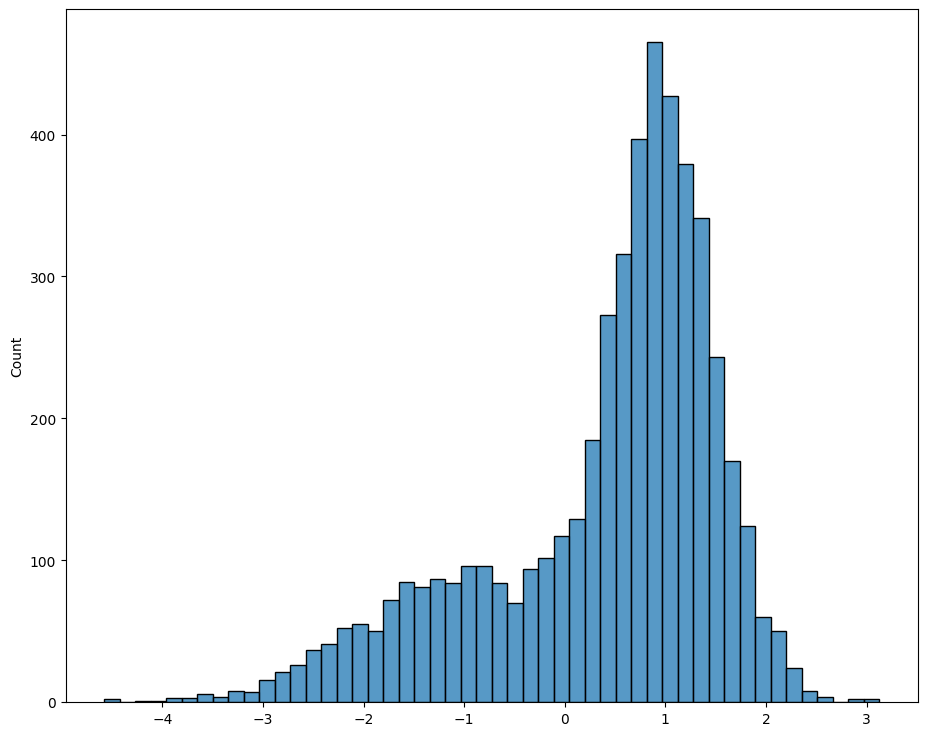

In [29]:
# Function to generate data given GMM parameters (GMM here is sum of two 1D Gaussians)

def gmm_generate_data(n, mu, tau, w):

    # Initialize model
    gmm_model = pm.Mixture.dist(
        w=w,
        comp_dists=[
            pm.Normal.dist(mu=mu[0], tau=tau[0]),
            pm.Normal.dist(mu=mu[1], tau=tau[1])
        ]
    )

    # Draw n samples
    samples = pm.draw(gmm_model, draws=n)

    # Return samples
    return samples

# Generate data for f(x|w,μ,τ) = 0.3*N(-1,1) + 0.7*N(1,0.5)
mu = np.array([-1, 1])
tau = np.array([1, 4]) # Equivalent to sigma = [1,0.5]
w = np.array([0.3, 0.7])
n = 5000
gmm_samples = gmm_generate_data(n, mu, tau, w)
sns.histplot(gmm_samples)

Now using these samples, infer the posterior distributions of each parameter.

In [30]:
# Define model

gmm_pymc_model = pm.Model()

with gmm_pymc_model:

    # Define priors
    w = pm.Dirichlet('w', a=np.ones(2))
    mu_1 = pm.Normal('mu_1', mu=0, tau=1)
    mu_2 = pm.Normal('mu_2', mu=0, tau=1)
    tau_1 = pm.Gamma('tau_1', alpha=1, beta=1)
    tau_2 = pm.Gamma('tau_2', alpha=1, beta=1)

    # Define likelihood
    likelihood = pm.Mixture('likelihood', w=w, comp_dists=[
        pm.Normal.dist(mu=mu_1, tau=tau_1),
        pm.Normal.dist(mu=mu_2, tau=tau_2)
    ], observed=gmm_samples)

    # Bayesian inference to approximate posterior
    trace = pm.sample(5000, chains=1, random_seed=100)


Mean: 0.69
94% HDI: [0.65 0.72]


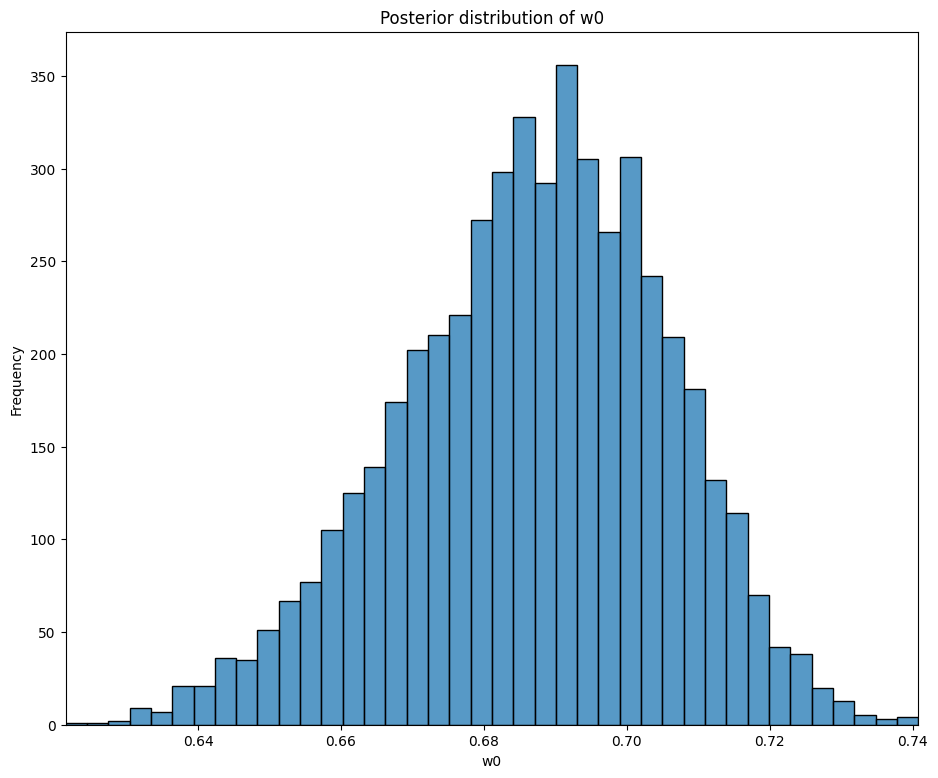


Mean: 0.31
94% HDI: [0.28 0.35]


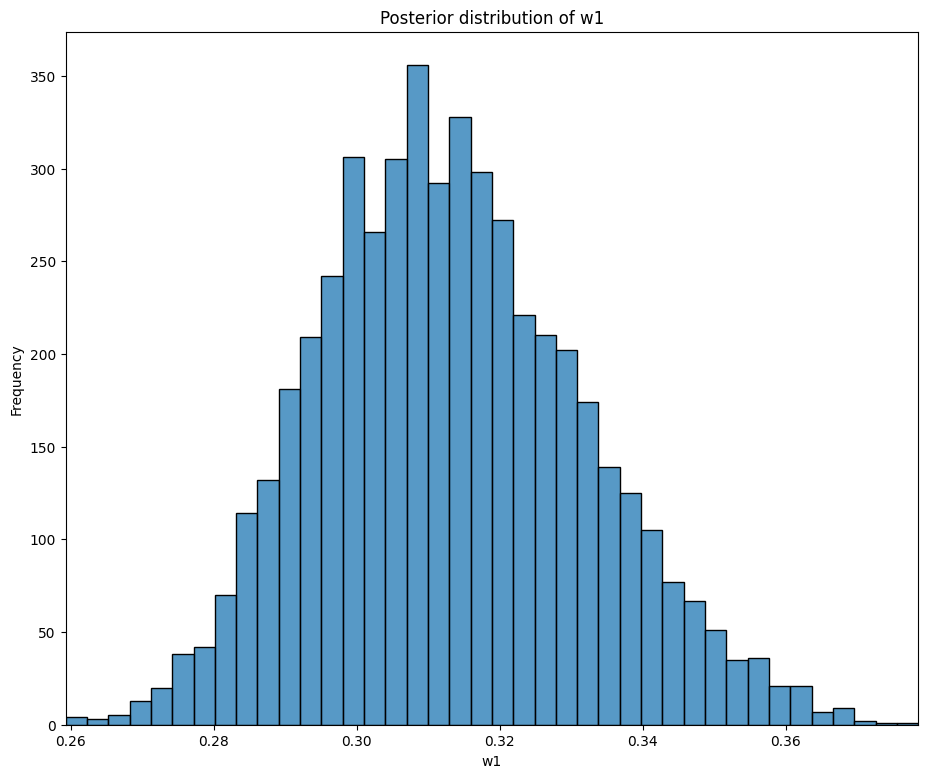


Mean: 1.0
94% HDI: [0.98 1.03]


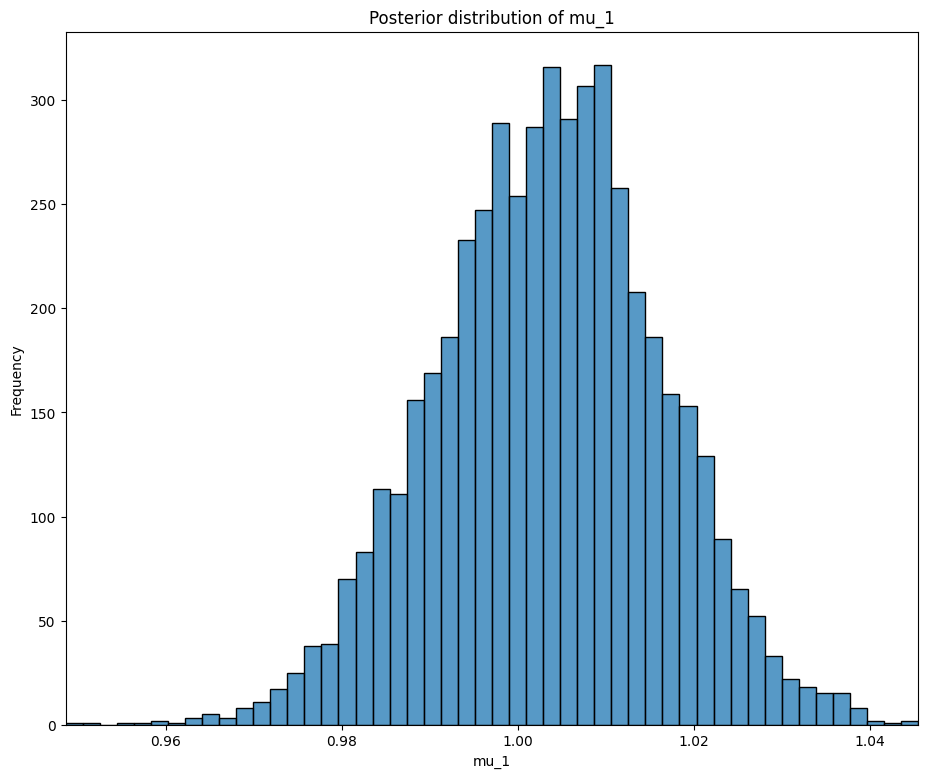


Mean: -0.96
94% HDI: [-1.12 -0.78]


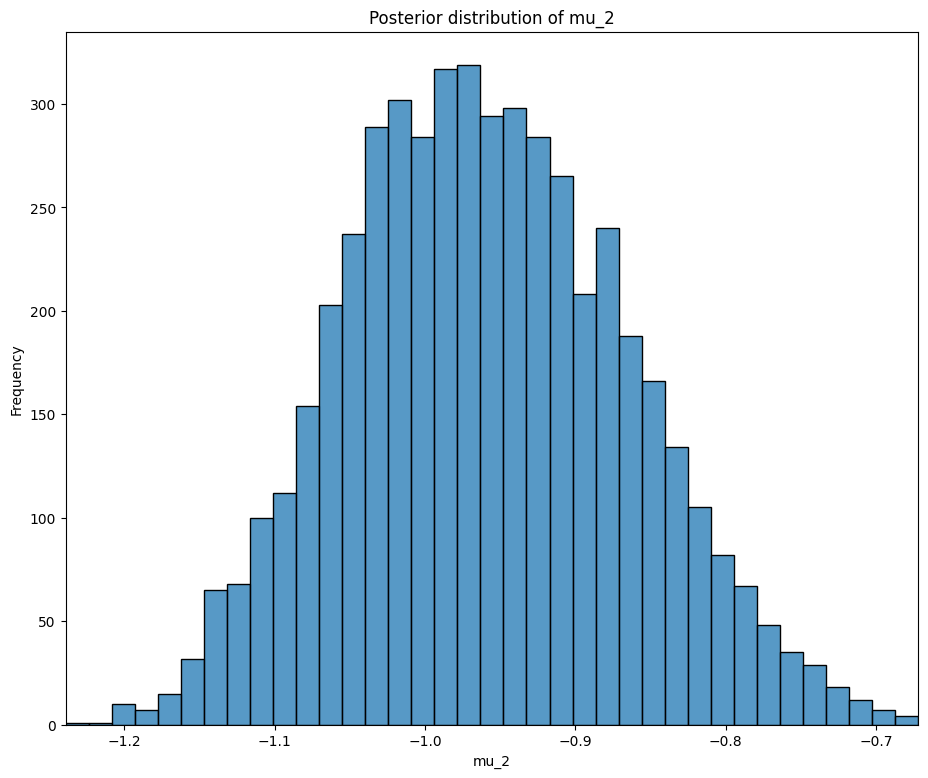


Mean: 3.87
94% HDI: [3.56 4.21]


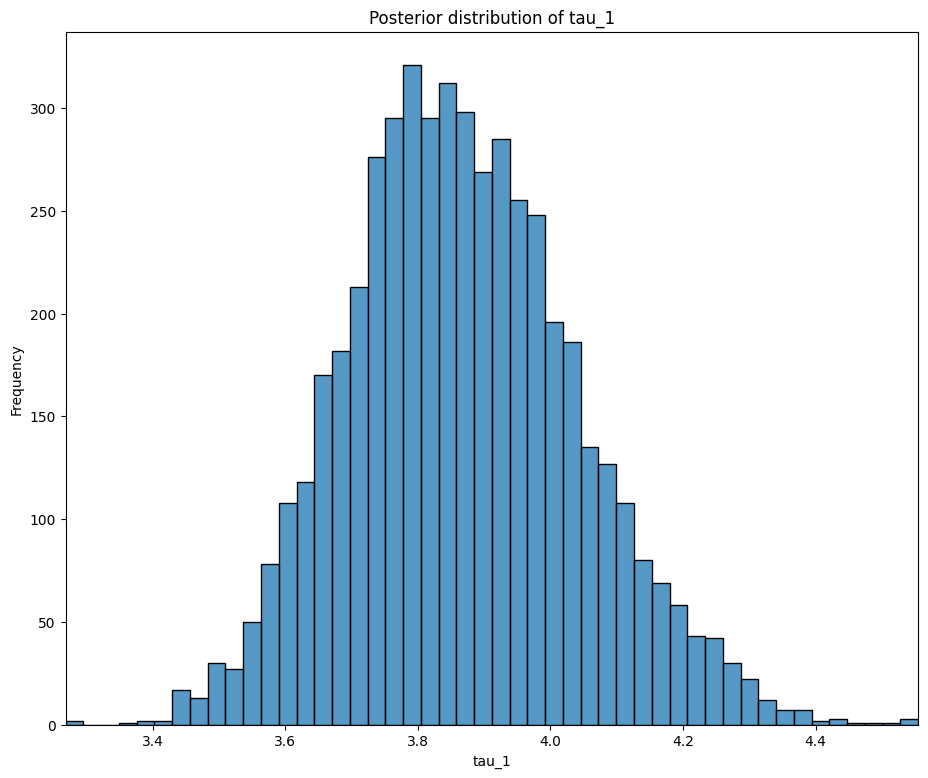


Mean: 0.87
94% HDI: [0.71 1.03]


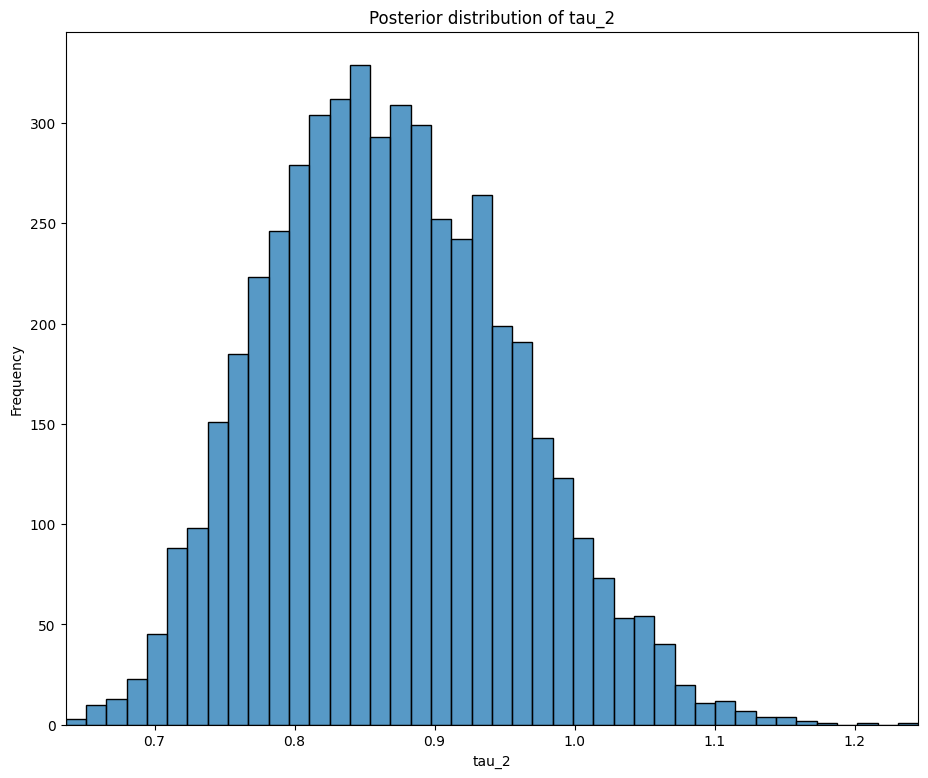

In [31]:
param_ids = ['w0', 'w1', 'mu_1', 'mu_2', 'tau_1', 'tau_2']

def gmm_posterior_plot(param_id, trace):

    if param_id == 'w0':
        y = trace.posterior['w'].values[:,:,0].flatten()
    elif param_id == 'w1':
        y = trace.posterior['w'].values[:,:,1].flatten()
    else:
        y = trace.posterior[param_id].values.flatten()
    ax = sns.histplot(y)
    ax.set_xlim(y.min(), y.max())
    ax.set_xlabel(param_id)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Posterior distribution of {param_id}')

    print(f"\nMean: {round(np.mean(y),2)}")
    hdi = az.hdi(y)
    print(f"94% HDI: [{round(hdi[0],2)} {round(hdi[1],2)}]")

for param_id in param_ids:
    gmm_posterior_plot(param_id, trace)
    plt.show()

### LDA on Toy Example

We'll first play around a toy corpus of 11 documents to familiarize ourselves with the gensim API. In the toy corpus presented, there are 5 documents that are river related and 6 finance related. The interesting part is that the corpus contains the word "bank" which could mean "a financial institution" or "a river bank". A good topic model should be able to tell the difference between these two meanings based on context.

In [32]:
# Each nested list represents the word of a document
texts = [['bank','river','shore','water'],
        ['river','water','flow','fast','tree'],
        ['bank','water','fall','flow'],
        ['bank','bank','water','rain','river'],
        ['river','water','mud','tree'],
        ['money','transaction','bank','finance'],
        ['bank','borrow','money'],
        ['bank','finance'],
        ['finance','money','sell','bank'],
        ['borrow','sell'],
        ['bank','loan','sell']]

# Build the dictionary and convert the documents to bag of words (bow) representation using the dictionary
texts_dictionary = corpora.Dictionary(texts)
texts_corpus = [texts_dictionary.doc2bow(text) for text in texts]

# Each document is a list of tuples, each tuple consists of (word_id, count)
texts_corpus

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(1, 1), (3, 1), (4, 1), (5, 1), (6, 1)],
 [(0, 1), (3, 1), (5, 1), (7, 1)],
 [(0, 2), (1, 1), (3, 1), (8, 1)],
 [(1, 1), (3, 1), (6, 1), (9, 1)],
 [(0, 1), (10, 1), (11, 1), (12, 1)],
 [(0, 1), (11, 1), (13, 1)],
 [(0, 1), (10, 1)],
 [(0, 1), (10, 1), (11, 1), (14, 1)],
 [(13, 1), (14, 1)],
 [(0, 1), (14, 1), (15, 1)]]

The following code chunk trains the LDA model using our corpus and dictionary. We set the number of topics to be 2, and expect to see one related to river banks, and one has to do with financial banks.

In [33]:
# Train the model: the more iterations, the more stable the model becomes, but of course takes longer to train
np.random.seed(431)
texts_model = LdaModel(
    texts_corpus,
    id2word = texts_dictionary,
    num_topics = 2,
    passes = 5,
    iterations = 50)

The $\texttt{show_topics}$ method from the model will output the most probable words that appear in each topic (topic-word distribution). For the gensim library, the default printing behavior is to print a linear combination of the top words sorted in decreasing order of the probability of the word appearing in that topic. Thus words that appear towards the left are the ones that are more indicative of the topic.



In [34]:
texts_model.show_topics()

[(0,
  '0.214*"bank" + 0.131*"sell" + 0.130*"finance" + 0.127*"money" + 0.092*"borrow" + 0.056*"loan" + 0.054*"transaction" + 0.028*"shore" + 0.025*"river" + 0.025*"water"'),
 (1,
  '0.181*"water" + 0.147*"bank" + 0.147*"river" + 0.084*"flow" + 0.083*"tree" + 0.050*"mud" + 0.050*"rain" + 0.050*"fall" + 0.050*"fast" + 0.042*"shore"')]

In [35]:
# We can pass the num_words argument to limit the listed number of most probable words
texts_model.show_topics(num_words = 5)

[(0,
  '0.214*"bank" + 0.131*"sell" + 0.130*"finance" + 0.127*"money" + 0.092*"borrow"'),
 (1,
  '0.181*"water" + 0.147*"bank" + 0.147*"river" + 0.084*"flow" + 0.083*"tree"')]

The LDA model shows that the two topics separate well (one about finance, the other about rivers). Bank is the most influential word in both the topics and other words help define what kind of bank we are talking about. We can also use the function $\texttt{get_term_topics}$ and $\texttt{get_document_topics}$ to further evaluate our result. $\texttt{get_term_topics}$ returns the odds of that particular word belonging to a particular topic. A few examples:

In [36]:
# Minimum probability parameter set to 0 to show likelihoods of all topics, returns (topic_label, likelihood)
print(texts_model.get_term_topics('water', minimum_probability=0))
print(texts_model.get_term_topics('bank', minimum_probability=0))

[(0, 0.009877404), (1, 0.16697578)]
[(0, 0.19870603), (1, 0.13300718)]


Note that $\texttt{get_term_topics}$ doesn't return actual probability values, but the values can be interpreted as relative likelihood. The term 'water' is much more likely to belong to topic 1 (rivers) than topic 0 (finance). Since the word bank is likely to be in both the topics, the values returned are closer in value.  

The $\texttt{get_document_topics}$ method outputs the topic distribution of the document.

In [37]:
# Get document-topic distribution of each document

for i in range(len(texts_corpus)):
    print(f'Document {i+1}:', texts[i])
    doc_topics = texts_model.get_document_topics(texts_corpus[i])
    print(f'Document-topic distribution: {doc_topics}')
    print()

Document 1: ['bank', 'river', 'shore', 'water']
Document-topic distribution: [(0, 0.122677214), (1, 0.8773228)]

Document 2: ['river', 'water', 'flow', 'fast', 'tree']
Document-topic distribution: [(0, 0.08577385), (1, 0.9142262)]

Document 3: ['bank', 'water', 'fall', 'flow']
Document-topic distribution: [(0, 0.11793279), (1, 0.8820672)]

Document 4: ['bank', 'bank', 'water', 'rain', 'river']
Document-topic distribution: [(0, 0.11204617), (1, 0.8879539)]

Document 5: ['river', 'water', 'mud', 'tree']
Document-topic distribution: [(0, 0.10295129), (1, 0.8970487)]

Document 6: ['money', 'transaction', 'bank', 'finance']
Document-topic distribution: [(0, 0.89181), (1, 0.10819)]

Document 7: ['bank', 'borrow', 'money']
Document-topic distribution: [(0, 0.863098), (1, 0.136902)]

Document 8: ['bank', 'finance']
Document-topic distribution: [(0, 0.81114614), (1, 0.18885386)]

Document 9: ['finance', 'money', 'sell', 'bank']
Document-topic distribution: [(0, 0.893031), (1, 0.10696897)]

Docu

Note the model can be used to infer document-topic distribution of new documents that contain words from the corpus vocabulary. Let us test this with two different documents which have the word bank in it, one in the finance context and one in the river context.

In [38]:
# Before we can infer topic distributions on new, unseen documents, we need to convert it to bag of words format first
bow_water = ['bank', 'water', 'bank']
bow = texts_model.id2word.doc2bow(bow_water)
doc_topics = texts_model.get_document_topics(bow)
print(f'Document-topic distribution: {doc_topics}')

Document-topic distribution: [(0, 0.26623914), (1, 0.7337609)]


In [39]:
bow_finance = ['bank', 'finance']
bow = texts_model.id2word.doc2bow(bow_finance)
doc_topics = texts_model.get_document_topics(bow)
print(f'Document-topic distribution: {doc_topics}')

Document-topic distribution: [(0, 0.811133), (1, 0.18886693)]
